<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Anchors" data-toc-modified-id="Anchors-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Anchors</a></span></li><li><span><a href="#Preparation-of-the-proposed-region-to-train-the-Fast-RCNN" data-toc-modified-id="Preparation-of-the-proposed-region-to-train-the-Fast-RCNN-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preparation of the proposed region to train the Fast RCNN</a></span></li><li><span><a href="#Region-proposal-network" data-toc-modified-id="Region-proposal-network-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Region proposal network</a></span></li><li><span><a href="#Load-train-dataset" data-toc-modified-id="Load-train-dataset-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Load train dataset</a></span><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Version-4---resize-des-images,-en-ne-gardant-que-les-bbox-et-category_id-des-targets-normalisées,-dans-un-array-de-dictionnaires-(targets-de-taille-variables)" data-toc-modified-id="Version-4---resize-des-images,-en-ne-gardant-que-les-bbox-et-category_id-des-targets-normalisées,-dans-un-array-de-dictionnaires-(targets-de-taille-variables)-4.0.0.1"><span class="toc-item-num">4.0.0.1&nbsp;&nbsp;</span>Version 4 - resize des images, en ne gardant que les bbox et category_id des targets normalisées, dans un array de dictionnaires (targets de taille variables)</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#Training-RPN-network" data-toc-modified-id="Training-RPN-network-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Training RPN network</a></span><ul class="toc-item"><li><span><a href="#Split-the-dataset" data-toc-modified-id="Split-the-dataset-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Split the dataset</a></span></li><li><span><a href="#Load-previous-trained-Fast-model" data-toc-modified-id="Load-previous-trained-Fast-model-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Load previous trained Fast model</a></span></li><li><span><a href="#Continue" data-toc-modified-id="Continue-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Continue</a></span></li><li><span><a href="#Transition-between-RPN-and-FastRCNN" data-toc-modified-id="Transition-between-RPN-and-FastRCNN-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Transition between RPN and FastRCNN</a></span></li><li><span><a href="#Fast-RCNN" data-toc-modified-id="Fast-RCNN-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Fast RCNN</a></span><ul class="toc-item"><li><span><a href="#Losses-for-Fast-RCNN" data-toc-modified-id="Losses-for-Fast-RCNN-5.5.1"><span class="toc-item-num">5.5.1&nbsp;&nbsp;</span>Losses for Fast RCNN</a></span></li><li><span><a href="#Training-for-Fast-RCNN" data-toc-modified-id="Training-for-Fast-RCNN-5.5.2"><span class="toc-item-num">5.5.2&nbsp;&nbsp;</span>Training for Fast RCNN</a></span></li></ul></li><li><span><a href="#Alternative-learning-startegy-:-we-learned-RPN-network-once-again-but-using-the-initilisation-given-by-Fast-RCNN." data-toc-modified-id="Alternative-learning-startegy-:-we-learned-RPN-network-once-again-but-using-the-initilisation-given-by-Fast-RCNN.-5.6"><span class="toc-item-num">5.6&nbsp;&nbsp;</span>Alternative learning startegy : we learned RPN network once again but using the initilisation given by Fast RCNN.</a></span></li><li><span><a href="#Final-architecture" data-toc-modified-id="Final-architecture-5.7"><span class="toc-item-num">5.7&nbsp;&nbsp;</span>Final architecture</a></span></li></ul></li></ul></div>

This notebook aims to provide functions that produce anchor boxes as decribed in the paper.

A box will be describe either as a numpy array $[y^-, x^-, y^+, x^+]$  or as a numpy array $[c_y, c_x, h,w]$

TODO : CHECK +1

In [ ]:
!pip3 install torch torchvision torchaudio

In [ ]:
!pip3 install pycocotools

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches #In order to draw the box ! (je sais pas pourquoi j'écris en anglais)
from torchvision import models
import torch.utils.data as data
from PIL import Image
import os
import os.path
import torchvision
import pycocotools
import copy
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

CUDA_LAUNCH_BLOCKING=1.

In [2]:
N_EPOCH = 10

# Anchors

In [3]:
def vertice_to_yxhw(anchor):
    res = (np.mean((anchor[0],anchor[2])),np.mean((anchor[1],anchor[3])), anchor[2] - anchor[0] + 1, anchor[3] - anchor[1]+1)
    return np.array(res)

In [4]:
def vertice_to_yxhw_array(anchor):
    res = (np.mean((anchor[:,0],anchor[:,2]), axis = 0),np.mean((anchor[:,1],anchor[:,3]), axis = 0), anchor[:,2] - anchor[:,0] + 1, anchor[:,3] - anchor[:,1]+1)
    return np.transpose(np.array(res))

In [5]:
def yxhw_to_vertice(anchor):
    res = (anchor[0] - anchor[2]/2, anchor[1] - anchor[3]/2, anchor[0] + anchor[2]/2, anchor[1] + anchor[3]/2)
    return np.array(res)

In [6]:
#xywh : top left
def xywh_to_vertice(anchor):
  anchor_perm = (anchor[1] - 0.5*anchor[3] ,anchor[0] + 0.5*anchor[2],anchor[3],anchor[2])
  return yxhw_to_vertice(anchor_perm)

In [7]:
def anchor_box(center, ratio, scale, shape_initial, shape_featured):
    sub_width = shape_initial[0]/shape_featured[0]
    sub_height = shape_initial[1]/shape_featured[1]
    anchor_width = sub_width*scale*np.sqrt(ratio)
    anchor_height = sub_height*scale/np.sqrt(ratio)
    
    ym = center[1] - anchor_height/2
    yp = center[1] + anchor_height/2
    xm = center[0] - anchor_width/2
    xp = center[0] + anchor_width/2
    
    anchor = (ym,xm,yp,xp)
    return(anchor)

In [8]:
def list_centers(shape_initial, shape_featured):
    ratio_h = shape_initial[1]/shape_featured[1]
    ratio_w = shape_initial[0]/shape_featured[0]
    #intiail center is the center at the left top corner
    all_centers = [np.array((ratio_w/2, ratio_h/2),dtype=float) + np.array((ratio_w*i, ratio_h*j),dtype=float) for i in range(int(shape_featured[0])) for j in range(int(shape_featured[1]))]
    return(all_centers)

In [9]:
def anchor_boxes(list_ratios, list_scales, shape_initial, shape_featured):
    list_center = list_centers(shape_initial, shape_featured)
    all_anchors = [anchor_box(center, ratio, scale,shape_initial,shape_featured) for center in list_center for ratio in list_ratios
                   for scale in list_scales]
    return(all_anchors)

In [10]:
def check_anchor_inside(anchor_box, shape_initial):
    ym = anchor_box[0]
    yp = anchor_box[2]
    xm = anchor_box[1]
    xp = anchor_box[3]
    is_inside = (min(xm,xp)>0) & (max(xm,xp)<shape_initial[0]) & (max(yp,ym) < shape_initial[1]) & (min(ym,yp) > 0) 
    return(is_inside)

In [11]:
def iou_anchors_vs_gtbox(list_anchors, list_gt_box):
  t_anchors = torch.tensor(np.array(list_anchors))
  t_list_gt_box = torch.tensor(np.array(list_gt_box))
  iou = torchvision.ops.box_iou(t_anchors, t_list_gt_box)
  return iou.numpy()

**TODO** : changer la forme de cette fonction en utilisant que des *arrays*.

In [12]:
#Return an array with :
#for all ground truth box, the anchors which maximize the IOU with it
#for all anchor, the max of the IOU

#the first column of the array is the index and the last the IOU 
def best_anchors_from_iou(dt_anchors_vs_gtbox):
    #index highest by gtbox (cond a)
    dt_anchors_vs_gtbox.argmax(axis = 0)
    ind_argmax = np.where(dt_anchors_vs_gtbox == dt_anchors_vs_gtbox.max(axis = 0))[0]
    cond_a = dt_anchors_vs_gtbox[ind_argmax,:].max(axis = 1)
    
    #highest by anchors box (cond b)
    index = dt_anchors_vs_gtbox.argmax(axis = 1)
    iou_max = dt_anchors_vs_gtbox.max(axis = 1)
    cond_b = dt_anchors_vs_gtbox[np.arange(dt_anchors_vs_gtbox.shape[0]),index]
    
    index_res = np.concatenate((ind_argmax,np.arange(dt_anchors_vs_gtbox.shape[0])))
    res = np.concatenate((cond_a, cond_b), axis=0)
    res = np.column_stack((index_res,res))
    return(res)

In [13]:
#label_from_iou returns a np.array containing for each anchor its label. (+1 if foreground, 0 if background and -1 if not used
#during the learning phase)
#The default thresholds are defined according the original paper about Fatest RCNN.

def label_from_iou(dt_anchors_vs_gtbox,pos_threshold = 0.7, neg_threshold = 0.3):
    label = np.full(dt_anchors_vs_gtbox.shape[0],-1)
    iou_max = dt_anchors_vs_gtbox.max(axis = 1)
    #positive labels : 1
    label[iou_max > pos_threshold] = 1
    #negative labels : 0
    label[iou_max < neg_threshold] = 0
    sum((iou_max < neg_threshold))

    #for anchors whose maximize IOU for a given object : +1
    dt_anchors_vs_gtbox.argmax(axis = 0)
    ind_argmax = np.where(dt_anchors_vs_gtbox == dt_anchors_vs_gtbox.max(axis = 0))[0]
    label[ind_argmax] = 1
    return(label)

In [14]:
def loc(anchor_box, gt_box):
    anchor_box = vertice_to_yxhw(anchor_box)
    gt_box = vertice_to_yxhw(gt_box)
    
    y = (gt_box[0] - anchor_box[0])/anchor_box[2]
    x = (gt_box[1] - anchor_box[1])/anchor_box[3]
    w = np.log(gt_box[3]/anchor_box[3])
    h = np.log(gt_box[2]/anchor_box[2])
    
    return np.array((y,x,h,w))

In [15]:
def loc_list(anchors_list, gt_list):
    anchor_box = vertice_to_yxhw_array(np.array(anchors_list))
    gt_box = vertice_to_yxhw_array(np.array(gt_list))
    
    y = (gt_box[:,0] - anchor_box[:,0])/anchor_box[:,2]
    x = (gt_box[:,1] - anchor_box[:,1])/anchor_box[:,3]
    w = np.log(gt_box[:,3]/anchor_box[:,3])
    h = np.log(gt_box[:,2]/anchor_box[:,2])
    return np.transpose(np.array((y,x,h,w)))

In [16]:
def deloc(anchor_box, reparam_box):
    anchor_box = vertice_to_yxhw(anchor_box)
    y = anchor_box[0] + (reparam_box[0] * anchor_box[2])
    x = anchor_box[1] + (reparam_box[1] * anchor_box[3])
    h = np.exp(reparam_box[2])*anchor_box[2]
    w = np.exp(reparam_box[3])*anchor_box[3]
    return np.array((y,x,h,w))

In [17]:
#anchors : vertice
#gt_list : prediction
def deloc_list(anchors_list, gt_list):
    anchor_box = vertice_to_yxhw_array(np.array(anchors_list))
    reparam_box = np.array(gt_list)
    
    y = anchor_box[:,0] + (reparam_box[:,0] * anchor_box[:,2])
    x = anchor_box[:,1] + (reparam_box[:,1] * anchor_box[:,3])
    h = np.exp(reparam_box[:,2])*anchor_box[:,2]
    w = np.exp(reparam_box[:,3])*anchor_box[:,3]
    
    #    res = (anchor[0] - anchor[2]/2, anchor[1] - anchor[3]/2, anchor[0] + anchor[2]/2, anchor[1] + anchor[3]/2)
    #   res = (np.mean((anchor[0],anchor[2])),np.mean((anchor[1],anchor[3])), anchor[2] - anchor[0] + 1, anchor[3] - anchor[1]+1)

    return np.transpose(np.array((y - h/2,x-w/2,y + h/2,x + w/2)))

In [18]:
def reparam_all_anchors(list_anchors, list_gt_box,iou,pos_threshold = 0.7, neg_threshold = 0.3):
    index_max_gtbox = iou.argmax(axis = 1)
    gt_box_by_anchors = [list_gt_box[i] for i in index_max_gtbox]
    #TODO : change suboptimal ZIP
    res = loc_list(list_anchors, gt_box_by_anchors)
    #compute labels
    labels = label_from_iou(iou, pos_threshold, neg_threshold)
    return list(res),labels

In [19]:
def deparam_all_anchors(list_anchors, list_box_param):
    res = [(deloc(anchor, box_param)) for anchor,box_param in zip(list_anchors, list_box_param)]
    return res

In [20]:
#TODO : heck how to fill when

def index_training_proposal(dt_anchors_vs_gtbox, nsize = 256, pos_ratio = 0.5,pos_threshold = 0.7, neg_threshold = 0.3):
    #number of positive units we need to reach in the training sample (we want a balanced sample)
    nb_pos_to_drawn = round(nsize*pos_ratio)
    lab = label_from_iou(dt_anchors_vs_gtbox, pos_threshold, neg_threshold)
    pos_lab = np.where(lab == 1)[0]
    neg_lab = np.where(lab == 0)[0]
    pos = len(pos_lab)
    neg = len(neg_lab)
    
    if (pos > nb_pos_to_drawn):
        disabled_index_pos = np.random.choice(pos_lab, size=(pos - nb_pos_to_drawn), replace = False)
        lab[disabled_index_pos] = -1
    
    if (neg > nsize - nb_pos_to_drawn):
        if(pos < nb_pos_to_drawn):
            disabled_index_neg = np.random.choice(neg_lab, size=(neg - nsize + pos), replace = False)
        else:
            disabled_index_neg = np.random.choice(neg_lab, size=(neg + nb_pos_to_drawn - nsize), replace = False)
        
        lab[disabled_index_neg] = -1    
    
    res = np.where((lab == 0) | (lab == 1))[0]
    return res

In [21]:
# def batch_training_proposal_RPN(image, feature_shape, ratios, scales,gt_box,nsize = 256, pos_ratio = 0.5, pos_threshold = 0.7, neg_threshold = 0.3):
#     #define all anchors using the feature map and the initial picture shapes.
#     anchors_boxes = anchor_boxes(ratios, scales, tuple(image.shape[2:]), tuple(feature_shape[2:]))
#     #check if each box is inside the initial image
#     index_boxes_inside = [j for j in range(len(anchors_boxes)) if check_anchor_inside(anchors_boxes[j], image_torch.shape[2:])]
#     anchors_boxes = [anchors_boxes[j] for j in index_boxes_inside]
#     #IOU anchors vs gt box
#     iou_anc_gt_box = iou_anchors_vs_gtbox(anchors_boxes, gt_box)
#     #Index of the units we keep
#     ind_for_sample = index_training_proposal(iou_anc_gt_box,nsize, pos_ratio)
#     anchors_boxes_reparam,lab_anchors = reparam_all_anchors(anchors_boxes,gt_box,iou_anc_gt_box,pos_threshold, neg_threshold)
#     return ({"image" : image, "boxes" : torch.from_numpy(np.array(anchors_boxes_reparam)[ind_for_sample,:]),
#              "labels" : torch.from_numpy(lab_anchors[ind_for_sample]), "indices" : np.array(index_boxes_inside)[ind_for_sample]})

In [22]:
#TODO : SUBTOPTIMAL

def batch_training_proposal_RPN(image, feature_shape, ratios, scales,gt_box,device, nsize = 256, pos_ratio = 0.5, pos_threshold = 0.7, neg_threshold = 0.3):
    #define all anchors using the feature map and the initial picture shapes.
    anchors_boxes = anchor_boxes(ratios, scales, tuple(image.shape[2:]), tuple(feature_shape[2:]))
    #check if each box is inside the initial image
    index_boxes_inside = [j for j in range(len(anchors_boxes)) if check_anchor_inside(anchors_boxes[j], image_torch.shape[2:])]
    anchors_boxes_checked = [anchors_boxes[j] for j in index_boxes_inside]
    #IOU anchors vs gt box
    iou_anc_gt_box = iou_anchors_vs_gtbox(anchors_boxes, gt_box)
    iou_anc_gt_box_check = iou_anc_gt_box[index_boxes_inside,:]
    #Index of the units we keep
    ind_for_sample = index_training_proposal(iou_anc_gt_box_check,nsize, pos_ratio)
    indice_to_kept = np.array(index_boxes_inside)[ind_for_sample]

    anchors_boxes_reparam,lab_anchors = reparam_all_anchors(anchors_boxes,gt_box,iou_anc_gt_box,pos_threshold, neg_threshold)

    final_label = np.full(len(anchors_boxes), -1)
    final_label[indice_to_kept] = lab_anchors[indice_to_kept]
    
    #we need initial anchors_boxes for training FastRNN part
    anchors_boxes = torch.from_numpy(np.array(anchors_boxes))
    return ({"image" : image.to(device), "boxes" : torch.from_numpy(np.array(anchors_boxes_reparam)).to(device),
             "labels" : torch.from_numpy(final_label).to(device), "anchors_initial" : anchors_boxes})

In [23]:
image_torch = 800*torch.rand((1,3,800,800))
feature_torch = torch.rand([1,512,50,50])

ratio = [0.5, 1, 2]
anchor_scales = [8, 16, 32]

gt_box = [np.array([20, 30, 400, 500]), np.array([300, 400, 500, 600])]
labels_gt_box = np.array(("chien","chat"))

In [24]:
def batch_training_proposal_multi_RPN(batch,feature_shape, ratio, scales,device,nsize = 256, pos_ratio = 0.5, pos_threshold = 0.7, neg_threshold = 0.3):
  image_torch, dict_label = batch
  boxes = [list(np.array(dict_label[j]["boxes"])) for j in range(len(dict_label))]  #remove empty one
  boxes = [[xywh_to_vertice(box) for box in box_list]for box_list in boxes]

  gt_labels = [list(np.array(dict_label[j]["labels"])) for j in range(len(dict_label))]  #remove empty one
  
  res = [batch_training_proposal_RPN(image_torch[j].unsqueeze(0), feature_shape, ratio, anchor_scales, boxes[j],device,nsize, pos_ratio, pos_threshold, neg_threshold) for j in range(len(boxes)) if len(boxes[j]) != 0]
  
  ind_with_box = torch.tensor([i for i in range(len(boxes)) if len(boxes[i]) != 0])
  image_torch = torch.index_select(image_torch,0, ind_with_box)
  boxes_fin = torch.stack([elem["boxes"] for elem in res])
  labels = torch.stack([elem["labels"] for elem in res])
  anchors = torch.stack([elem["anchors_initial"] for elem in res])

  return {"images" : image_torch.to(device), "boxes": boxes_fin.to(device), "labels": labels.to(device),"gt_box": boxes, "gt_labels": gt_labels, "anchors": anchors}

# Preparation of the proposed region to train the Fast RCNN

In [25]:
def clip_predicted_boxes(list_box, th_min, th_max):
    list_box = np.array(list_box)
    return list(np.clip(list_box,th_min,th_max))

In [26]:
#remove all boxes with at least the width or the height less that 16
def boxes_hw_min(list_box, list_score, min_size = 16):
    boxes = np.array(list_box)
    height = boxes[:, 2] - boxes[:, 0]
    width = boxes[:, 3] - boxes[:, 1]
    box_kept = np.where((height > min_size) & (width > min_size))[0]
    list_box_kept = list(boxes[box_kept])
    list_score = [list_score[j] for j in box_kept]
    return list_box_kept, list_score

In [27]:
def nms(list_box, list_score, top_pre, top_post, thresold):
    list_score = np.array(list_score)
    order = list_score.argsort()[::-1]
    order = order[:top_pre]
    keep = []
    list_box = np.array(list_box)
    
    ym = list_box[:,0]
    xm = list_box[:,1]
    yp = list_box[:,2]
    xp = list_box[:,3]
    areas = (xp - xm + 1) * (yp - ym + 1)

    while len(order)>0:
        i = order[0]
        yym = np.maximum(ym[i], ym[order[1:]])
        xxm = np.maximum(xm[i], xm[order[1:]])
        yyp = np.minimum(yp[i], yp[order[1:]])
        xxp = np.minimum(xp[i], xp[order[1:]])
        
        width = np.maximum(0.0, xxp - xxm + 1)
        height = np.maximum(0.0, yyp - yym + 1)
        intersection = width*height
        ovr = intersection/(areas[i] + areas[order[1:]] - intersection)
        
        ind_to_keep = np.where(ovr <= thresold)[0]
        order = order[ind_to_keep + 1]
        keep.append(i)
    
    keep = keep[:top_post]
    return(list_box[keep,:])

# Region proposal network

In [28]:
#boxes as tensor [N, 5]
def roi_pooling(boxes, feature_map,scale,adaptative_max_pool):
    boxes_coord = boxes[:,1:].mul(scale).long() #scale + round
    res = [feature_map.narrow(0, boxes[i,0].int(),1)[..., boxes_coord[i,1]:(boxes_coord[i,3]+1), boxes_coord[i,0]:(boxes_coord[i,2]+1)] for i in range(boxes_coord.shape[0])]
    res = [adaptative_max_pool(element) for element in res]
    res = torch.cat(res, axis = 0)
    return(res)

In [29]:
#0 in labels_gt_box must be the background
def batch_training_proposal_FastRCNN(feature_map,list_box,list_gt_box,labels_gt_box, nsize = 128, pos_ratio = 0.25, pos_iou_threshold = 0.5,
                                    neg_iou_threshold_p = 0.5, neg_iou_threshold_n = 0.0, adaptative_max_pool = torch.nn.AdaptiveMaxPool2d((7,7),return_indices=False),scale = 1):

    #number of positive units we need to reach in the training sample (we want a balanced sample)
    nb_pos_to_drawn = round(nsize*pos_ratio)
    iou = iou_anchors_vs_gtbox(list_box, list_gt_box)
    #compute the maximum for each anchor
    gt_roi_label = np.argmax(iou, axis = 1)
    gt_roi_max = np.max(iou, axis = 1)
    labels = labels_gt_box[gt_roi_label]
    #assign the label if greater that pos_iou_threshold
    #assign background if between the two negative thresholds
    gt_pos = np.where((gt_roi_max > pos_iou_threshold))[0]
    gt_neg = np.where((gt_roi_max < neg_iou_threshold_p) & (gt_roi_max > neg_iou_threshold_n))[0] #background -- 0

    #Nb of positives and negatives boxes get using the thresholds
    pos = len(gt_pos)
    neg = len(gt_neg)
    
    enable_index_pos = np.array([],dtype=int)

    #Subsampling from it
    if (pos > nb_pos_to_drawn):
        disabled_index_pos = np.random.choice(range(len(gt_pos)), size=(pos - nb_pos_to_drawn), replace = False)
        gt_pos = np.delete(gt_pos, disabled_index_pos)

    if (neg > nsize - nb_pos_to_drawn):
#         if(pos < nb_pos_to_drawn):
#             print(neg)
#             print(pos)
#             print(nsize)
#             disabled_index_neg = np.random.choice(range(len(gt_neg)), size=(neg - nsize + pos), replace = False)
#             gt_neg = np.delete(gt_neg, disabled_index_neg)
#         else:
        disabled_index_neg = np.random.choice(range(len(gt_neg)), size=(neg + nb_pos_to_drawn - nsize), replace = False)
        gt_neg = np.delete(gt_neg, disabled_index_neg)

    if(neg + pos < nsize):
        enable_index_pos = np.random.choice(np.append(gt_pos,gt_neg),size = nsize - neg - pos, replace = True)
        
    
        
    
    #if negative : assign background labels with it's 0
    labels[gt_neg] = 0
    final_index = np.append(np.append(gt_pos,gt_neg),enable_index_pos)
    #Non reparams
    non_reparam = np.array(list_box)[final_index,:]
    #Need to transform from yxhw to xywh
    non_reparam = non_reparam[:,(1,0,3,2)]
    non_reparam = np.hstack((np.zeros((non_reparam.shape[0],1)), non_reparam))
    non_reparam = torch.from_numpy(non_reparam)

    data_for_training = roi_pooling(non_reparam, feature_map,scale, adaptative_max_pool)
    #Reparams
    reparam = [loc(box,gt_box) for box,gt_box in zip(non_reparam, list(np.array(list_gt_box)[gt_roi_label,:]))]
    
    return  data_for_training, reparam,labels[final_index]

# Load train dataset 

J'ai réussi à utiliser l'API Coco via `torchvision.datasets.CocoDetection` (https://pytorch.org/vision/stable/datasets.html)


In [28]:
#Permet d'utiliser la co des serveurs Google (rip la mienne) et assure une meilleure reproductibilité
!wget "https://conservancy.umn.edu/bitstream/handle/11299/214865/dataset.zip?sequence=12&isAllowed=y"
!unzip "dataset.zip?sequence=12&isAllowed=y"

--2021-12-30 15:22:16--  https://conservancy.umn.edu/bitstream/handle/11299/214865/dataset.zip?sequence=12&isAllowed=y
Resolving conservancy.umn.edu (conservancy.umn.edu)... 128.101.122.105
Connecting to conservancy.umn.edu (conservancy.umn.edu)|128.101.122.105|:443... connected.
HTTP request sent, awaiting response... 200 200
Length: 553029970 (527M) [application/zip]
Saving to: ‘dataset.zip?sequence=12&isAllowed=y.2’

?sequence=12&isAllo  10%[=>                  ]  58.00M  12.8MB/s    eta 43s    ^C
Archive:  dataset.zip?sequence=12&isAllowed=y
replace dataset/README.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [30]:
from torchvision import datasets
from torch.utils.data import DataLoader

In [31]:
# The directory containing the source images
data_path = "dataset/instance_version/train"

# The path to the COCO labels JSON file
labels_path = "dataset/instance_version/instances_train_trashcan.json"

#### Version 4 - resize des images, en ne gardant que les bbox et category_id des targets normalisées, dans un array de dictionnaires (targets de taille variables)

In [134]:
#Attention "bbox": [x,y,width,height]
class CocoDetection_diy_bis(data.Dataset) :
    """`MS Coco Detection <http://mscoco.org/dataset/#detections-challenge2016>`_ Dataset.

    Args:
        root (string): Root directory where images are downloaded to.
        annFile (string): Path to json annotation file.
        resize : (int,int) size of the images wanted 
    """

    def __init__(self, root, annFile, size, elements_index):
        from pycocotools.coco import COCO
        self.root = root
        self.coco = COCO(annFile)
        self.total_ids = list(self.coco.imgs.keys())
        self.ids = [self.total_ids[j] for j in elements_index]
        self.size = size
        self.transform = transforms.Compose([transforms.Resize(size), transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: Tuple (image, target). target is the object returned by ``coco.loadAnns``.
        """
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        target = coco.loadAnns(ann_ids)

        path = coco.loadImgs(img_id)[0]['file_name']

        # Resize des images :
        img = Image.open(os.path.join(self.root, path)).convert('RGB')
        original_size = img.size
        img = self.transform(img)

        # Targets dict :
        targets = {'labels':[],'boxes':[]}

        for elem in target :  
          box = np.copy(elem['bbox'])
          box[0] *= self.size[0] / original_size[0]
          box[1] *= self.size[1] / original_size[1]
          box[2] *= self.size[0] / original_size[0]
          box[3] *= self.size[1] / original_size[1]
          targets['boxes'].append(box)
          targets['labels'].append(elem['category_id'])

        return img, targets
        


    def __len__(self):
        return len(self.ids)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

In [33]:
def collate_fn_diy (batch) : 
    """
    Parameters : 
    -----------
    batch : list of tuples (img,targets)

    Return : 
    -------
    images : tensor of dim batch_size x 3 x 224 x 224
    targets : list of dict containing : 
        - "labels": Tensor of dim [num_target_boxes] (where num_target_boxes is the number of ground-truth objects in the target) containing the class labels
        - "boxes": Tensor of dim [num_target_boxes, 4] containing the target box coordinates
    """
    imgs, trgts = list(zip(*batch)) # imgs et trgts sont désormais des batch_size-tuples 

    imgs = [img.unsqueeze(0) for img in list(imgs)] #ajout d'une dimension supplémentaire à tous les tenseurs
    images = torch.cat(imgs) # concaténation en un seul tenseur

    targets = []
    for t in list(trgts) : 
      targets.append({'labels' : torch.from_numpy(np.array(t["labels"])), 
                      'boxes' : torch.from_numpy(np.array(t["boxes"]))})
    
    return images, targets


TODO : que faire lorsqu'on a des images sans box et sans label donc ?

# Training RPN network

In [34]:
from torchvision import models

resnet50 = models.resnet50(pretrained=True)
image_torch = 800*torch.rand((1,3,800,800))
#We choose the place where we extracted the feature map in order to get H_feature * W_feature around 2400 (papers)
resnet50_features = nn.Sequential(*(list(resnet50.children())[:-5]))
resnet50_features(image_torch).shape

torch.Size([1, 256, 200, 200])

https://stackoverflow.com/questions/69480764/what-is-the-difference-between-resnet50-vgg16-etc-and-rcnn-faster-rcnn


In [35]:
class RPN(nn.Module):
    #TODO : remove embedding_dim using wv.shape[1]
    #define all the layers used in model
    def __init__(self,mid_channels, in_channels,nb_anchors,pre_trained_model):
        
        #Constructor
        super().__init__()        
        
        #embedding layer
        self.pre_trained_model = pre_trained_model
        self.conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv1.bias.data.zero_()
        self.sm = nn.Softmax(dim = 2)
        self.reg_layer = nn.Conv2d(mid_channels, nb_anchors *4, 1, 1, 0)
        self.reg_layer.weight.data.normal_(0, 0.01)
        self.reg_layer.bias.data.zero_()

        self.cls_layer = nn.Conv2d(mid_channels, nb_anchors *2, 1, 1, 0)
        # classification layer
        self.cls_layer.weight.data.normal_(0, 0.01)
        self.cls_layer.bias.data.zero_()
       

    def forward(self,img):
        nb_images = img.shape[0] #sale ?
        x = self.pre_trained_model(img)
        x = self.conv1(x)
        pred_anchor = self.reg_layer(x)
        pred_anchor = pred_anchor.permute(0, 2, 3, 1).contiguous().view(nb_images, -1, 4)
        
        pred_cls = self.cls_layer(x)
        pred_cls = pred_cls.permute(0, 2, 3, 1).contiguous()
        pred_cls = pred_cls.view(nb_images, -1, 2)
        #pred_cls = self.sm(pred_cls)
        return pred_anchor, pred_cls

In [36]:
def l1smooth(pred,target,nb_anchors = 9):
  #zeros for those which are negative
  boxes = ((target["labels"] == 1).unsqueeze(-1).repeat(1,1,4).float() * target['boxes'])
  pred = ((target["labels"] == 1).unsqueeze(-1).repeat(1,1,4).float() * pred[0])
  x = torch.abs(boxes.flatten() - pred.flatten())
  return sum(0.5*(x**2)*(x < 1) + (x - 0.5)*(x >= 1)) / nb_anchors

In [37]:
def RPN_loss(pred,target,feature_shape, loss_ce = nn.CrossEntropyLoss(ignore_index=-1),loss_sml1 = nn.SmoothL1Loss(reduction = "sum"),  lamb = 10):
  #Remove all -1 for the computation of the CE loss
  #Classification part
  loss_cls = loss_ce(pred[1].view(-1,2),target['labels'].view(-1,1).squeeze().long())
  #Regression part
  boxes = ((target["labels"] == 1).unsqueeze(-1).repeat(1,1,4).float() * target['boxes'])
  pred = ((target["labels"] == 1).unsqueeze(-1).repeat(1,1,4).float() * pred[0])
  loss_reg = loss_sml1(boxes, pred)/torch.prod(feature_shape[2:])
  #Final loss
  loss = loss_cls + lamb*loss_reg
  return loss

def RPN_loss2(pred,target, nb_anchors = 56*56, lamb = 10):
  #Remove all -1 for the computation of the CE loss
  #Classification part
  loss_ce = nn.CrossEntropyLoss(ignore_index=-1)
  loss_cls = loss_ce(pred[1].view(-1,2),target['labels'].view(-1,1).squeeze().long())
  #Regression part
  loss_reg = l1smooth(pred, target, nb_anchors)
  #Final loss
  loss = loss_cls + lamb*loss_reg
  return loss

The new version of RPN is at least 8 time faster.

As indicated in the paper, we are using SGD optimiser with 0.001 as learning rate and 0.9 for momemtum

In [38]:
def fn_train_step_RPN(model, loss_fn, optimizer,feature_shape = torch.tensor((1,1,56,56))):
  def train_step(data_loader):
    model.train()
    losses = 0
    for input in data_loader:
      input = batch_training_proposal_multi_RPN(input, feature_shape, ratio, anchor_scales, device)
      output = model_RPN(input["images"])

      loss = RPN_loss(output, input,feature_shape)
      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      losses =+ loss.item()

    return losses/len(data_loader)

  return train_step

## Split the dataset

In [39]:
prop_train = 0.5
prop_valid = 0.3
prop_test = 0.2

n = 6000
n_train = int(n*prop_train)
n_test = int(n*prop_test)
n_valid = n - n_train- n_test

ind_n_train = np.random.choice(np.arange(n), n_train)
ind_n_test = np.random.choice(np.setdiff1d(np.arange(n), ind_n_train), n_test)
ind_n_valid = np.setdiff1d(np.setdiff1d(np.arange(n), ind_n_train),ind_n_test)

#train Dataloader
instances_train = CocoDetection_diy_bis(root = data_path, annFile = labels_path, size=(224,224), elements_index = ind_n_train)
instances_train_dataloader = DataLoader(instances_train, batch_size=1, shuffle=True, collate_fn = collate_fn_diy)

#valid dataloader
instances_valid = CocoDetection_diy_bis(root = data_path, annFile = labels_path, size=(224,224), elements_index = ind_n_valid)
instances_valid_dataloader = DataLoader(instances_valid, batch_size=1, shuffle=True, collate_fn = collate_fn_diy)


#test dataloader
instances_test = CocoDetection_diy_bis(root = data_path, annFile = labels_path, size=(224,224), elements_index = ind_n_test)
instances_test_dataloader = DataLoader(instances_test, batch_size=1, shuffle=True, collate_fn = collate_fn_diy)


loading annotations into memory...
Done (t=0.29s)
creating index...
index created!
loading annotations into memory...
Done (t=0.24s)
creating index...
index created!
loading annotations into memory...
Done (t=0.34s)
creating index...
index created!


In [40]:
import torch.optim as optim

feature_shape = (1,1,56,56)
model_RPN = RPN(256,256,9,resnet50_features).to(device)
optimizer = optim.SGD(model_RPN.parameters(), lr=0.001, momentum=0.9)
best_model = RPN(256,256,9,resnet50_features).to(device)


In [ ]:
import time
#TODO : save better model ! on valid ?
t0 = time.time()
loss_list_train = [float('inf')]
loss_list_valid = [float('inf')]
nb_epoch = N_EPOCH
i = 0


for epoch in range(nb_epoch):
  #training
  model_RPN.train()
  losses = 0
  for element in instances_train_dataloader:
        if(len(element[1][0]["labels"]) != 0):
            input = batch_training_proposal_multi_RPN(element, feature_shape, ratio, anchor_scales, device)
            output = model_RPN(input["images"])
            loss = RPN_loss(output, input,torch.tensor(feature_shape))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses =+ loss.item()
  loss_epch = losses/len(instances_train_dataloader)
  loss_list_train.append(loss_epch)
  #valid
  with torch.no_grad():
    losses = 0
    for element in instances_valid_dataloader:
        if(len(element[1][0]["labels"]) != 0):
          input = batch_training_proposal_multi_RPN(element, feature_shape, ratio, anchor_scales, device)
          output = model_RPN(input["images"])
          model_RPN.eval()
          loss = RPN_loss(output, input, torch.tensor(feature_shape))
          losses =+ loss.item()
    loss_epch_valid = losses/len(instances_valid_dataloader)
    if loss_epch_valid < min(loss_list_valid):
        best_model = (copy.deepcopy(model_RPN.state_dict()))
        #Ajoutez des métriques
    loss_list_valid.append(loss_epch_valid)
    print(f'\tEpoch {i} : Train Loss: {loss_epch:.3f} | \tValid Loss: {loss_epch_valid:.3f}')
  i += 1
 

t1 = time.time()

total = t1-t0


In [ ]:
torch.save(best_model, "model_RPN.pt")

## Load previous trained Fast model

In [ ]:
model_RPN = RPN(256,256,9,resnet50_features).to(device)
model_RPN.load_state_dict(torch.load("model_RPN.pt"))

## Continue

In [ ]:
exemple = next(iter(instances_train_dataloader))
exemple = batch_training_proposal_multi_RPN(exemple, feature_shape, ratio, anchor_scales, device)

In [ ]:
exemple["gt_box"]

In [ ]:
model_RPN(exemple["images"])

Il est possible d'utiliser directement le tensor image

## Transition between RPN and FastRCNN

https://www.youtube.com/watch?v=cSO1nUj495Y&ab_channel=ArdianUmam

In [ ]:
batch_exemple = next(iter(instances_train_dataloader))
exemple =  batch_training_proposal_multi_RPN(batch_exemple, feature_shape, ratio, anchor_scales, device)

In [ ]:
pre_trained_model_after_RPN = model_RPN._modules["pre_trained_model"]

In [ ]:
#0 in labels_gt_box must be the background
def batch_training_proposal_FastRCNN(feature_map,list_box,list_gt_box,labels_gt_box,device, nsize = 128, pos_ratio = 0.25, pos_iou_threshold = 0.5,
                                    neg_iou_threshold_p = 0.5, neg_iou_threshold_n = 0.0, adaptative_max_pool = torch.nn.AdaptiveMaxPool2d((7,7),return_indices=False),
                                     scale = 1):

    #number of positive units we need to reach in the training sample (we want a balanced sample)
    nb_pos_to_drawn = round(nsize*pos_ratio)
    iou = iou_anchors_vs_gtbox(list_box, list_gt_box)
    #compute the maximum for each anchor
    gt_roi_label = np.argmax(iou, axis = 1)
    gt_roi_max = np.max(iou, axis = 1)
    labels = labels_gt_box[gt_roi_label]
    #assign the label if greater that pos_iou_threshold
    #assign background if between the two negative thresholds
    gt_pos = np.where((gt_roi_max > pos_iou_threshold))[0]
    gt_neg = np.where((gt_roi_max < neg_iou_threshold_p) & (gt_roi_max > neg_iou_threshold_n))[0] #background -- 0

    #Nb of positives and negatives boxes get using the thresholds
    pos = len(gt_pos)
    neg = len(gt_neg)
    
    enable_index_pos = np.array([],dtype=int)
    
    #Subsampling from it
    if (pos > nb_pos_to_drawn):
        disabled_index_pos = np.random.choice(range(len(gt_pos)), size=(pos - nb_pos_to_drawn), replace = False)
        gt_pos = np.delete(gt_pos, disabled_index_pos)

    if (neg > nsize - nb_pos_to_drawn):
        disabled_index_neg = np.random.choice(range(len(gt_neg)), size=(neg + nb_pos_to_drawn - nsize), replace = False)
        gt_neg = np.delete(gt_neg, disabled_index_neg)

    if(len(gt_neg) + len(gt_pos) < nsize):
        enable_index_pos = np.random.choice(np.append(gt_pos,gt_neg),size = nsize - (len(gt_neg) + len(gt_pos)), replace = True)
        
    #if negative : assign background labels with it's 1000
    labels[gt_neg] = 1000
    labels[np.where(labels != 1000)] = 412 #imagenet for trashes
    final_index = np.append(np.append(gt_pos,gt_neg),enable_index_pos)
    #Non reparams
    non_reparam = np.array(list_box)[final_index,:]
    #Need to transform from yxhw to xywh
    non_reparam_xywh = non_reparam[:,(1,0,3,2)]
    non_reparam_xywh = np.hstack((np.zeros((non_reparam_xywh.shape[0],1)), non_reparam_xywh))
    non_reparam_torch = torch.from_numpy(non_reparam_xywh)
    

    data_for_training = roi_pooling(non_reparam_torch, feature_map,scale, adaptative_max_pool)
    array_gt_box_for_each = np.array(list_gt_box)[gt_roi_label,:]
    reparam = loc_list(non_reparam, array_gt_box_for_each[final_index,:])
    return  {'feature_map_extract' : data_for_training.to(device), 'boxes' : torch.tensor(np.array(reparam)).to(device), 
             'labels' : torch.tensor(np.array(labels[final_index])).to(device), 'non_reparam_box' : torch.from_numpy(non_reparam).to(device)}
#data for training : set of extracted part of feature maps using roi pooling
#boxes
#labels for each boxes : ATTENTION PASSE EN IMAGENET !

In [ ]:
#exemple batch containing a single exemple
sm = nn.Softmax(dim = 2)
def RPN_to_FRCNN(exemple, feature_size, min_size_anchors, before_top_nms,after_top_nms,pos_t, model, feature_map):
    #no learning in this part !
    with torch.no_grad():
        res = model(exemple["images"])
    
    prob = sm(res[0])[0,:,1].detach().cpu().numpy()
    anchors = list(np.array(exemple["anchors"][0].cpu()))
    list_box = list((res[0][0].detach().cpu()).numpy())
    boxes_hw = boxes_hw_min(clip_predicted_boxes(deloc_list(anchors,list_box),0,feature_size),prob,min_size_anchors)
    list_box = list(nms(boxes_hw[0], boxes_hw[1], before_top_nms,after_top_nms,pos_t))
    return {"feature_map" : feature_map, "list_roi" : list_box, "list_gt_labels" : np.array(exemple["gt_labels"][0]), "list_gt_box" : list(exemple["gt_box"][0])}

after_rpn = RPN_to_FRCNN(exemple, 224,16,12000,1000,0.7,model_RPN, pre_trained_model_after_RPN(exemple["images"]))

res = batch_training_proposal_FastRCNN(after_rpn["feature_map"],after_rpn["list_roi"],after_rpn["list_gt_box"],after_rpn["list_gt_labels"],device,
                                       nsize = 128, pos_ratio = 0.25, pos_iou_threshold = 0.5,
                                adaptative_max_pool = torch.nn.AdaptiveMaxPool2d((7,7),return_indices=False), scale = 1/4)

## Fast RCNN

In [ ]:
class Fast_RCNN(nn.Module):
    #TODO : remove embedding_dim using wv.shape[1]
    #define all the layers used in model
    def __init__(self,in_channels,mid_channels,nb_classes,pre_trained_model,min_size_anchors,
                 before_top_nms,after_top_nms,pos_t, model_RPN, nsize, 
                 pos_ratio, pos_iou_threshold, number_roi_pooling, scale):
        
        #Constructor
        super().__init__()        
        
        self.in_channels = in_channels
        self.mid_channels = mid_channels
        self.nb_classes = nb_classes
        self.pre_trained_model = pre_trained_model
        self.min_size_anchors = min_size_anchors
        self.before_top_nms = before_top_nms
        self.after_top_nms = after_top_nms
        self.pos_t = pos_t
        self.model_RPN = model_RPN
        
        #for batch FRCNN
        self.nsize = nsize
        self.pos_ratio = pos_ratio
        self.pos_iou_threshold = pos_iou_threshold
        self.number_roi_pooling = number_roi_pooling
        self.scale = scale
        
        #embedding layer
        self.pre_trained_model = pre_trained_model
        self.lin1 = nn.Linear(in_channels, mid_channels)
        self.lin2 = nn.Linear(mid_channels, mid_channels)
        self.score = nn.Linear(mid_channels, (nb_classes + 1))
        self.boxes = nn.Linear(mid_channels, 4*(nb_classes + 1))
        
        self.boxes.weight.data.normal_(0, 0.01)
        self.boxes.bias.data.zero_()

        self.score.weight.data.normal_(0, 0.01)
        self.score.bias.data.zero_()
       
    
        
    def forward(self,batch):
        nb_images = batch["images"].shape[0] #sale ?
        feature_maped = self.pre_trained_model(batch["images"].to(device))
        after_rpn = RPN_to_FRCNN(batch,batch["images"].shape[-1],self.min_size_anchors,self.before_top_nms,self.after_top_nms,self.pos_t,self.model_RPN, feature_maped)
        minibatch_FRCNN = batch_training_proposal_FastRCNN(after_rpn["feature_map"],after_rpn["list_roi"],after_rpn["list_gt_box"],after_rpn["list_gt_labels"], 
                                                           device,nsize = self.nsize, pos_ratio = self.pos_ratio, pos_iou_threshold = self.pos_iou_threshold,
                                adaptative_max_pool = torch.nn.AdaptiveMaxPool2d((self.number_roi_pooling,self.number_roi_pooling),return_indices=False),
                                                           scale = self.scale)
        x = minibatch_FRCNN["feature_map_extract"] #put the feature map extracted
        x = x.view(128, -1) #128 as parameters
        x = self.lin1(x)
        x = self.lin2(x)
        x_score = self.score(x)
        x_boxes = self.boxes(x)
        return x_boxes,x_score, minibatch_FRCNN

#def RPN_to_FRCNN(exemple, feature_size, min_size_anchors, before_top_nms,after_top_nms,pos_t, model, feature_map):


In [ ]:
from torchvision import models

resnet50 = models.resnet50(pretrained=True)
image_torch = 800*torch.rand((1,3,800,800))
#We choose the place where we extracted the feature map in order to get H_feature * W_feature around 2400 (papers)
resnet50_features = nn.Sequential(*(list(resnet50.children())[:-5]))

In [ ]:
fast_rcnn = Fast_RCNN(12544, 4096, 1000, resnet50_features,16,12000,1000,0.7,model_RPN,128,0.25,0.5,7,1/4).to(device)

### Losses for Fast RCNN

In [ ]:
#target : results of batch_training_proposal_FastRCNN function (dict with featured_extracted, boxes, labels)
#pred : resultats of forward function

def FRCNN_loss(pred,target, loss_ce = nn.CrossEntropyLoss(ignore_index=-1),loss_sml1 = nn.SmoothL1Loss(reduction = "sum"),  lamb = 1):
  #Remove all -1 for the computation of the CE loss
  #Classification part
  loss_cls = loss_ce(pred[1],target["labels"])
  #Regression part ("1000" is the background)
  boxes = (res["labels"] != 1000).unsqueeze(-1).repeat(1,1,4).float() * res["boxes"]
  nb_feature = pred[0].shape[0]
  pred = pred[0].view(nb_feature,-1,4)[torch.arange(0,nb_feature).long(), res["labels"]] * (res["labels"] != 1000).unsqueeze(-1).repeat(1,1,4).float() 
  loss_reg = loss_sml1(boxes, pred)
  #Final loss
  loss = loss_cls + lamb*loss_reg
  return loss

### Training for Fast RCNN

In [ ]:
resnet50 = models.resnet50(pretrained=True)
resnet50_features = nn.Sequential(*(list(resnet50.children())[:-5]))

In [ ]:
import torch.optim as optim

fast_rcnn = Fast_RCNN(12544, 4096, 1000, copy.deepcopy(resnet50_features),16,12000,1000,0.7,model_RPN,128,0.25,0.5,7,1/4).to(device)
optimizer = optim.SGD(fast_rcnn.parameters(), lr=0.001, momentum=0.9)
best_model_frcnn = Fast_RCNN(12544, 4096, 1000, copy.deepcopy(resnet50_features),16,12000,1000,0.7,model_RPN,128,0.25,0.5,7,1/4).to(device)


In [ ]:
import time
#TODO : save better model ! on valid ?
t0 = time.time()
loss_list_train = [float('inf')]
loss_list_valid = [float('inf')]
nb_epoch = N_EPOCH
i = 0


for epoch in range(nb_epoch):
  #training
  fast_rcnn.train()
  losses = 0
  for element in instances_train_dataloader:
    if(len(element[1][0]["labels"]) != 0):
        exemple =  batch_training_proposal_multi_RPN(batch_exemple, feature_shape, ratio, anchor_scales, device)    
        output = fast_rcnn(exemple)
        loss = FRCNN_loss(output, output[2])
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses =+ loss.item()
  loss_epch = losses/len(instances_train_dataloader)
  loss_list_train.append(loss_epch)
  #valid
  with torch.no_grad():
    losses = 0
    for element in instances_valid_dataloader:
        if(len(element[1][0]["labels"]) != 0):
          input = batch_training_proposal_multi_RPN(element, feature_shape, ratio, anchor_scales, device)
          output = fast_rcnn(exemple)
          fast_rcnn.eval()
          loss = FRCNN_loss(output, output[2])
          losses =+ loss.item()
    loss_epch_valid = losses/len(instances_valid_dataloader)
    if loss_epch_valid < min(loss_list_valid):
        print(True)
        best_model_frcnn = copy.deepcopy(fast_rcnn.state_dict())
        #Ajoutez des métriques
    loss_list_valid.append(loss_epch_valid)
    print(f'\tEpoch {i} : Train Loss: {loss_epch:.3f} | \tValid Loss: {loss_epch_valid:.3f}')
  i += 1

t1 = time.time()


In [ ]:
torch.save(best_model_frcnn,"model_frcnn.pt")

## Alternative learning startegy : we learned RPN network once again but using the initilisation given by Fast RCNN. 

In [ ]:
fast_rcnn.load_state_dict(torch.load("model_frcnn.pt"))

In [ ]:
feature_extractor_after_FRCNN = copy.deepcopy(fast_rcnn.pre_trained_model)
feature_shape = (1,1,56,56)

model_RPN_after_FRCNN = RPN(256,256,9,feature_extractor_after_FRCNN).to(device)

Freeze pre-trained model 

In [ ]:
for param in model_RPN_after_FRCNN.pre_trained_model.parameters():
    param.requires_grad = False

In [ ]:
import torch.optim as optim

optimizer = optim.SGD(model_RPN_after_FRCNN.parameters(), lr=0.001, momentum=0.9)

Learning

In [ ]:
import time
#TODO : save better model ! on valid ?
t0 = time.time()
loss_list_train = [float('inf')]
loss_list_valid = [float('inf')]
nb_epoch = N_EPOCH
i = 0

best_model_afterFRCNN = RPN(256,256,9,feature_extractor_after_FRCNN).to(device)

for epoch in range(nb_epoch):
  #training
  model_RPN_after_FRCNN.train()
  losses = 0
  for element in instances_train_dataloader:
        if(len(element[1][0]["labels"]) != 0):
            input = batch_training_proposal_multi_RPN(element, feature_shape, ratio, anchor_scales, device)
            output = model_RPN_after_FRCNN(input["images"])
            loss = RPN_loss(output, input,torch.tensor(feature_shape))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            losses =+ loss.item()
  loss_epch = losses/len(instances_train_dataloader)
  loss_list_train.append(loss_epch)
  #valid
  with torch.no_grad():
    losses = 0
    for element in instances_valid_dataloader:
        if(len(element[1][0]["labels"]) != 0):
          input = batch_training_proposal_multi_RPN(element, feature_shape, ratio, anchor_scales, device)
          output = model_RPN_after_FRCNN(input["images"])
          model_RPN_after_FRCNN.eval()
          loss = RPN_loss(output, input, torch.tensor(feature_shape))
          losses =+ loss.item()
    loss_epch_valid = losses/len(instances_valid_dataloader)
    if loss_epch_valid < min(loss_list_valid):
        best_model_afterFRCNN = (copy.deepcopy(model_RPN.state_dict()))
        #Ajoutez des métriques
    loss_list_valid.append(loss_epch_valid)
    print(f'\tEpoch {i} : Train Loss: {loss_epch:.3f} | \tValid Loss: {loss_epch_valid:.3f}')
  i += 1
 

t1 = time.time()

total = t1-t0

In [ ]:
torch.save(best_model_afterFRCNN, "RPN_after_FRCNN.pt")

Alternat

In [ ]:
model_RPN_after_FRCNN.load_state_dict(torch.load("RPN_after_FRCNN.pt"))

In [ ]:
import torch.optim as optim

fast_rcnn_after_alter = Fast_RCNN(12544, 4096, 1000, copy.deepcopy(model_RPN_after_FRCNN.pre_trained_model),16,12000,1000,0.7,
                                  copy.deepcopy(model_RPN_after_FRCNN),128,0.25,0.5,7,1/4).to(device)
best_model_frcnn_after_alter = Fast_RCNN(12544, 4096, 1000, copy.deepcopy(model_RPN_after_FRCNN.pre_trained_model),16,12000,1000,0.7,
                                  copy.deepcopy(model_RPN_after_FRCNN),128,0.25,0.5,7,1/4).to(device)
optimizer = optim.SGD(fast_rcnn_after_alter.parameters(), lr=0.0001, momentum=0.9)

In [ ]:
for param in fast_rcnn_after_alter.pre_trained_model.parameters():
    param.requires_grad = False

In [ ]:
import time
#TODO : save better model ! on valid ?
t0 = time.time()
loss_list_train = [float('inf')]
loss_list_valid = [float('inf')]
nb_epoch = N_EPOCH
i = 0

for epoch in range(nb_epoch):
  #training
  fast_rcnn_after_alter.train()
  losses = 0
  for element in instances_train_dataloader:
    exemple =  batch_training_proposal_multi_RPN(batch_exemple, feature_shape, ratio, anchor_scales, device)    
    output = fast_rcnn_after_alter(exemple)
    loss = FRCNN_loss(output, output[2])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses =+ loss.item()
  loss_epch = losses/len(instances_train_dataloader)
  loss_list_train.append(loss_epch)
  #valid
  with torch.no_grad():
    losses = 0
    for element in instances_valid_dataloader:
        if(len(element[1][0]["labels"]) != 0):
          input = batch_training_proposal_multi_RPN(element, feature_shape, ratio, anchor_scales, device)
          output = fast_rcnn_after_alter(exemple)
          fast_rcnn_after_alter.eval()
          loss = FRCNN_loss(output, output[2])
          losses =+ loss.item()
    loss_epch_valid = losses/len(instances_valid_dataloader)
    if loss_epch_valid < min(loss_list_valid):
        best_model_frcnn_after_alter = copy.deepcopy(fast_rcnn_after_alter.state_dict())
        #Ajoutez des métriques
    loss_list_valid.append(loss_epch_valid)
    print(f'\tEpoch {i} : Train Loss: {loss_epch:.3f} | \tValid Loss: {loss_epch_valid:.3f}')
  i += 1

t1 = time.time()

In [ ]:
torch.save(best_model_frcnn_after_alter, "final_model.pt")

## Final architecture

In [76]:
model_RPN_after = RPN(256,256,9,copy.deepcopy(resnet50_features)).to(device)

model_RPN_after.load_state_dict(torch.load("RPN_after_FRCNN.pt"))

<All keys matched successfully>

In [77]:
fast_rcnn = Fast_RCNN(12544, 4096, 1000, copy.deepcopy(model_RPN_after.pre_trained_model),16,12000,1000,0.7,
                      model_RPN_after,128,0.25,0.5,7,1/4).to(device)

In [78]:
fast_rcnn.load_state_dict(torch.load("final_model.pt"))

<All keys matched successfully>

In [79]:
batch_exemple = next(iter(instances_train_dataloader))
exemple =  batch_training_proposal_multi_RPN(batch_exemple, feature_shape, ratio, anchor_scales, device)

0.4666666666666667


In [80]:
after_rpn = RPN_to_FRCNN(exemple, 224,16,12000,1000,0.7,model_RPN, model_RPN_after.pre_trained_model(exemple["images"]))

res = batch_training_proposal_FastRCNN(after_rpn["feature_map"],after_rpn["list_roi"],after_rpn["list_gt_box"],after_rpn["list_gt_labels"],device,
                                       nsize = 128, pos_ratio = 0.25, pos_iou_threshold = 0.5,
                                adaptative_max_pool = torch.nn.AdaptiveMaxPool2d((7,7),return_indices=False), scale = 1/4)

In [81]:
def prediction_to_pict_and_boxes(exemple, model, iou_min = 0.2,
                                invTrans = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)):
    pred = model(exemple)

    tables = [table.squeeze().detach().cpu().numpy() for table in pred[0].view(128,-1,4).split(1,1)]

    res_deparam = deloc_list(np.repeat(pred[2]["non_reparam_box"].detach().cpu().numpy(),1001,axis = 1),
                            np.hstack(tables))

    res_deparam = res_deparam.clip(0, 255)
    
    sm1 = nn.Softmax(dim = 1)
    proba = sm1(model(exemple)[1])

    score = proba[:,411]
    ind = torchvision.ops.batched_nms(torch.from_numpy(res_deparam).to(device), score, torch.zeros(res_deparam.shape[0]).to(device),
                                      iou_min)

    box_to_keep = res_deparam[ind.cpu().numpy(),:]

    box_to_keep = box_to_keep.clip(0,255)
    box = box_to_keep[:, (1,0,3,2)]
    
    return {"images" : invTrans(exemple["images"]), "boxes" : box}

In [82]:
def pictures_and_boxes(image_tensor, boxes):
    img = transforms.functional.to_pil_image(image_tensor.squeeze())
    draw = ImageDraw.Draw(img)
    for box in boxes.tolist():
        draw.rectangle(xy = box)
    #Add grown trunth :
    gt_box = [box[[1,0,3,2]] for box in exemple["gt_box"][0]]  
    print(box)
    for gtb in gt_box:
        draw.rectangle(xy = gtb.tolist(), outline = "red")
    return(img)

0.4666666666666667
[0.0, 0.0, 0.2689736932516098, 0.4433048591017723]


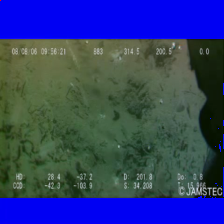

In [135]:
batch_exemple = next(iter(instances_train_dataloader))
exemple =  batch_training_proposal_multi_RPN(batch_exemple, feature_shape, ratio, anchor_scales, device)
res = prediction_to_pict_and_boxes(exemple, fast_rcnn)
pictures_and_boxes(res["images"],res["boxes"])

In [136]:
next(iter(instances_train))

0.4666666666666667


(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
          [-1.9980, -1.9980, -1.9980,  ..., -1.9980, -1.9980, -1.9980]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [137]:
instances_train2 = CocoDetection_diy_bis(root = data_path, annFile = labels_path, size=(224,224), elements_index = ind_n_train)
instances_train_dataloader2 = DataLoader(instances_train2, batch_size=1, shuffle=False, collate_fn = collate_fn_diy)

loading annotations into memory...
Done (t=0.26s)
creating index...
index created!


In [145]:
print(next(iter(instances_train2)))
print(next(iter(instances_train_dataloader2)))

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.0665, -2.0665, -2.0665,  ..., -2.0665, -2.0665, -2.0665],
         [-1.9980, -1.9980, -1.9980,  ..., -1.9980, -1.9980, -1.9980]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0182, -2.0182, -2.0182,  ..., -2.0182, -2.0182, -2.0182],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -